**Install Packages and Dependencies**

In [ ]:
!sudo apt-get update

In [ ]:
!sudo apt-get install python-dev ipython python-numpy python-matplotlib python-scipy cython

In [ ]:
!pip install ipython numpy matplotlib scipy cython

In [ ]:
!mkdir -p /content/sounds
!rm /content/sounds/piano_foo.wav
!curl --output /content/sounds/piano_foo.wav "https://storage.googleapis.com/mikmusic-8c7e3.appspot.com/DFT/piano_foo.wav"

In [ ]:
%cd /content/

**Import Packages**

In [59]:
import numpy as np
import time, os, sys, math
import matplotlib.pyplot as plt
import scipy as scipy
import IPython.display as ipd
from IPython.display import display, Markdown
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.io.wavfile import write, read



**Define STFT Filter Function**

In [60]:
#
# Derivative version of code from SMS-TOOLS
#  

tol = 1e-14                                                 # threshold used to compute phase

def isPower2(num):
	"""
	Check if num is power of two
	"""
	return ((num & (num - 1)) == 0) and num > 0


def dftAnal(x, w, N):
	"""
	Analysis of a signal using the discrete Fourier transform
	x: input signal, w: analysis window, N: FFT size 
	returns mX, pX: magnitude and phase spectrum
	"""

	if not(isPower2(N)):                                 # raise error if N not a power of two
		raise ValueError("FFT size (N) is not a power of 2")

	if (w.size > N):                                        # raise error if window size bigger than fft size
		raise ValueError("Window size (M) is bigger than FFT size")

	hN = (N//2)+1                                           # size of positive spectrum, it includes sample 0
	hM1 = (w.size+1)//2                                     # half analysis window size by rounding
	hM2 = w.size//2                                         # half analysis window size by floor
	fftbuffer = np.zeros(N)                                 # initialize buffer for FFT
	w = w / sum(w)                                          # normalize analysis window
	xw = x*w                                                # window the input sound
	fftbuffer[:hM1] = xw[hM2:]                              # zero-phase window in fftbuffer
	fftbuffer[-hM2:] = xw[:hM2]        
	X = scipy.fft.fft(fftbuffer)                                      # compute FFT
	absX = abs(X[:hN])                                      # compute ansolute value of positive side
	absX[absX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
	mX = 20 * np.log10(absX)                                # magnitude spectrum of positive frequencies in dB
	X[:hN].real[np.abs(X[:hN].real) < tol] = 0.0            # for phase calculation set to 0 the small values
	X[:hN].imag[np.abs(X[:hN].imag) < tol] = 0.0            # for phase calculation set to 0 the small values         
	pX = np.unwrap(np.angle(X[:hN]))                        # unwrapped phase spectrum of positive frequencies
	return mX, pX

def dftSynth(mX, pX, M):
	"""
	Synthesis of a signal using the discrete Fourier transform
	mX: magnitude spectrum, pX: phase spectrum, M: window size
	returns y: output signal
	"""

	hN = mX.size                                            # size of positive spectrum, it includes sample 0
	N = (hN-1)*2                                            # FFT size
	if not(isPower2(N)):                                 # raise error if N not a power of two, thus mX is wrong
		raise ValueError("size of mX is not (N/2)+1")

	hM1 = int(math.floor((M+1)/2))                          # half analysis window size by rounding
	hM2 = int(math.floor(M/2))                              # half analysis window size by floor
	fftbuffer = np.zeros(N)                                 # initialize buffer for FFT
	y = np.zeros(M)                                         # initialize output array
	Y = np.zeros(N, dtype = complex)                        # clean output spectrum
	Y[:hN] = 10**(mX/20) * np.exp(1j*pX)                    # generate positive frequencies
	Y[hN:] = 10**(mX[-2:0:-1]/20) * np.exp(-1j*pX[-2:0:-1]) # generate negative frequencies
	fftbuffer = np.real(scipy.fft.ifft(Y))                            # compute inverse FFT
	y[:hM2] = fftbuffer[-hM2:]                              # undo zero-phase window
	y[hM2:] = fftbuffer[:hM1]
	return y

def stft(x, w, N, H):
	"""
	Analysis/synthesis of a sound using the short-time Fourier transform
	x: input sound, w: analysis window, N: FFT size, H: hop size
	returns y: output sound
	"""
	
	if (H <= 0):                                   # raise error if hop size 0 or negative
		raise ValueError("Hop size (H) smaller or equal to 0")
		
	M = w.size                                     # size of analysis window
	hM1 = (M+1)//2                                 # half analysis window size by rounding
	hM2 = M//2                                     # half analysis window size by floor
	x = np.append(np.zeros(hM2),x)                 # add zeros at beginning to center first window at sample 0
	x = np.append(x,np.zeros(hM1))                 # add zeros at the end to analyze last sample
	pin = hM1                                      # initialize sound pointer in middle of analysis window       
	pend = x.size-hM1                              # last sample to start a frame
	w = w / sum(w)                                 # normalize analysis window
	y = np.zeros(x.size)                           # initialize output array
	while pin<=pend:                               # while sound pointer is smaller than last sample      
	#-----analysis-----  
		x1 = x[pin-hM1:pin+hM2]                    # select one frame of input sound
		mX, pX = dftAnal(x1, w, N)             # compute dft
	#-----synthesis-----
		y1 = dftSynth(mX, pX, M)               # compute idft
		y[pin-hM1:pin+hM2] += H*y1                 # overlap-add to generate output sound
		pin += H                                   # advance sound pointer
	y = np.delete(y, range(hM2))                   # delete half of first window which was added in stftAnal
	y = np.delete(y, range(y.size-hM1, y.size))    # delete half of the last window which as added in stftAnal
	return y

def stftAnal(x, w, N, H) :
	"""
	Analysis of a sound using the short-time Fourier transform
	x: input array sound, w: analysis window, N: FFT size, H: hop size
	returns xmX, xpX: magnitude and phase spectra
	"""
	if (H <= 0):                                   # raise error if hop size 0 or negative
		raise ValueError("Hop size (H) smaller or equal to 0")
		
	M = w.size                                      # size of analysis window
	hM1 = (M+1)//2                                  # half analysis window size by rounding
	hM2 = M//2                                      # half analysis window size by floor
	x = np.append(np.zeros(hM2),x)                  # add zeros at beginning to center first window at sample 0
	x = np.append(x,np.zeros(hM2))                  # add zeros at the end to analyze last sample
	pin = hM1                                       # initialize sound pointer in middle of analysis window       
	pend = x.size-hM1                               # last sample to start a frame
	w = w / sum(w)                                  # normalize analysis window
	xmX = []                                       # Initialise empty list for mX
	xpX = []                                       # Initialise empty list for pX
	while pin<=pend:                                # while sound pointer is smaller than last sample      
		x1 = x[pin-hM1:pin+hM2]                     # select one frame of input sound
		mX, pX = dftAnal(x1, w, N)              # compute dft
		xmX.append(np.array(mX))                    # Append output to list
		xpX.append(np.array(pX))
		pin += H                                    # advance sound pointer
	xmX = np.array(xmX)                             # Convert to numpy array
	xpX = np.array(xpX)
	return xmX, xpX

def stftSynth(mY, pY, M, H) :
	"""
	Synthesis of a sound using the short-time Fourier transform
	mY: magnitude spectra, pY: phase spectra, M: window size, H: hop-size
	returns y: output sound
	"""
	hM1 = (M+1)//2                                   # half analysis window size by rounding
	hM2 = M//2                                       # half analysis window size by floor
	nFrames = mY[:,0].size                           # number of frames
	y = np.zeros(nFrames*H + hM1 + hM2)              # initialize output array
	pin = hM1                  
	for i in range(nFrames):                         # iterate over all frames      
		y1 = dftSynth(mY[i,:], pY[i,:], M)       # compute idft
		y[pin-hM1:pin+hM2] += H*y1                   # overlap-add to generate output sound
		pin += H                                     # advance sound pointer
	y = np.delete(y, range(hM2))                     # delete half of first window which was added in stftAnal
	y = np.delete(y, range(y.size-hM1, y.size))      # delete the end of the sound that was added in stftAnal
	return y


In [61]:
#
# filter the source audio using the given window, fft bin size, hop size, 
# and filter coefficients
#
def stftFiltering(samples, sampleRate, window, N, H, filter):
	"""
	Apply a filter to a sound by using the STFT
	samples: input sound, sampleRate, window: analysis window, N: FFT size, H: hop size
	filter: magnitude response of filter with frequency-magnitude pairs (in dB)
	returns y: output sound
	"""


	M = window.size                              # size of analysis window
	hM1 = int(math.floor((M+1)/2))               # half analysis window size by rounding
	hM2 = int(math.floor(M/2))                   # half analysis window size by floor
	samples = np.append(np.zeros(hM2),samples)   # add zeros at beginning to center first window at sample 0
	samples = np.append(samples,np.zeros(hM1))   # add zeros at the end to analyze last sample
	pos = hM1                                    # initialize sound pointer in middle of analysis window       
	pend = samples.size-hM1                      # last sample to start a frame
	window = window / sum(window) 							 # normalize analysis window
	y = np.zeros(samples.size)                   # initialize output array
	while pos<=pend:                             # while sound pointer is smaller than last sample      
	#-----analysis-----  
		x1 = samples[pos-hM1:pos+hM2]              # select one frame of input sound
		mX, pX = dftAnal(x1, window, N)             # compute dft (mX magnitude, pX phase)
	#------transformation-----
		mY = mX + filter                           # filter input magnitude spectrum (apply filter)
	#-----synthesis-----
		y1 = dftSynth(mY, pX, M)               # compute idft (invesrve dft) - produces samples
		y[pos-hM1:pos+hM2] += H*y1                 # overlap-add to generate output sound
		pos += H                                   # advance sound pointer
	y = np.delete(y, range(hM2))                 # delete half of first window which was added in stftAnal
	y = np.delete(y, range(y.size-hM1, y.size))  # add zeros at the end to analyze last sample
	return y


**Filter and Do Analysis**

Hanning Window we use for the Short Fourier Transform

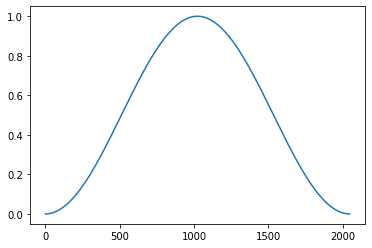

Filter Shape (Cutoff:1000 HZ) and Input/Output Spectrograms 

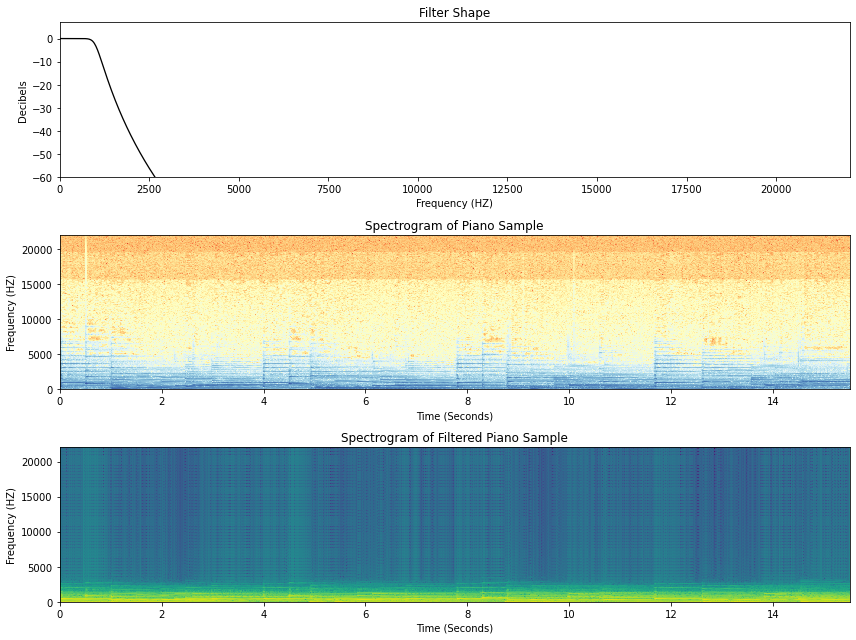

In [62]:
# READ AUDIO FILE 
# fs is sample rate 
# originalSamples is sample array 

(fs, originalSamples) = read('./sounds/piano_foo.wav')

# W is the window size used to sample audio for stft
W = 2048
# N is the number of sample points used to create FFT 
N = 2048
# H is hop size, which is smaller than N 
H = 512



# create the window we will use to sample audio for stft 
hanningWindow = np.hanning(W)

# plot the window 
display(Markdown('Hanning Window we use for the Short Fourier Transform'))

plt.plot(hanningWindow)
plt.show()

#create butterworth filter 
cutoffFrequency = 1000  # Cut-off frequency of the filter

normalizedFreq = cutoffFrequency / (fs / 2) # Normalize the frequency (Nyquist)

#compute butterworth filter curve
#NOTE: I don't get this butterworth generation stuff completely 
b, a = scipy.signal.butter(7, normalizedFreq, btype='low', analog=False)
#produce N/2 + 1 frequency components to match STFT output bins 
_, h = scipy.signal.freqz(b, a,worN=(N//2+1))
#convert amplitude values to decibels (DB)
butterworthFilter = 20*np.log10(abs(h))


# Run STFTT over x samples (numpy array), given fs sample rate, w - filter window (numpy array), N - FFT bin size, H - hop size
# filtBuffer - the butterworth filter (numpy array)
filteredSamples = stftFiltering(originalSamples, fs, hanningWindow, N, H, butterworthFilter)

# now analyze original and filtered 
# m_ is magnitude , while p_ is phase information 

mX,pX = stftAnal(originalSamples, hanningWindow, N, H)
mY,pY = stftAnal(filteredSamples, hanningWindow, N, H)


#color map stuff 
orangecm = cm.get_cmap('Oranges_r', 256)
#newcmp = ListedColormap(orangecm, name='Orange')



#plot spectrograms 
display(Markdown('Filter Shape (Cutoff:' + str(cutoffFrequency) +' HZ) and Input/Output Spectrograms '))


fig, ax = plt.subplots(3, 1, figsize=(12, 9))

#plt.subplot(311)
ax[0].plot(fs*np.arange(mX[0,:].size)/float(N), butterworthFilter, 'k', lw=1.3)
ax[0].axis([0, fs/2, -60, 7])
ax[0].set_title('Filter Shape')
ax[0].set_xlabel('Frequency (HZ)')
ax[0].set_ylabel('Decibels')


#ax[0].show()



#plt.subplot(312)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(mX[0,:].size)*float(fs)/N                         
ax[1].pcolormesh(frmTime, binFreq, np.transpose(mX),cmap='RdYlBu')
ax[1].set_title('Spectrogram of Piano Sample')
ax[1].set_xlabel('Time (Seconds)')
ax[1].set_ylabel('Frequency (HZ)')
ax[1].autoscale(tight=True)
#ax[1].show()


#plt.subplot(313)
numFrames = int(mY[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(mY[0,:].size)*float(fs)/N                         
ax[2].pcolormesh(frmTime, binFreq, np.transpose(mY))
ax[2].set_title('Spectrogram of Filtered Piano Sample')
ax[2].set_xlabel('Time (Seconds)')
ax[2].set_ylabel('Frequency (HZ)' )
ax[2].autoscale(tight=True)

fig.tight_layout()

#UF.wavwrite(filteredSamples, fs, 'piano_audio_filtered_high.wav')
write('piano_audio_filtered_high.wav',fs,filteredSamples.astype(np.int16))
plt.savefig('piano_audio_filtered_high.png')
#plt.show()




In [63]:
display(Markdown('Original Sample'))
ipd.Audio('./sounds/piano_foo.wav')

Original Sample

In [64]:
display(Markdown('Filtered Sample'))
ipd.Audio('piano_audio_filtered_high.wav')

Filtered Sample